# Figure 5- V2 animals are more motivated


In [1]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, friedmanchisquare, wilcoxon, ks_2samp
import statsmodels.stats.multitest as smm
from itertools import combinations
import statsmodels.formula.api as smf
import itertools

sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

# Data Load


In [2]:
pdf = u.load_poke_df()

Loading poke data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


# Utility Functions


In [3]:
"""Statistical Functions"""
def check_normality(data, alpha=0.05):
    """
    Returns True if data passes the Shapiro–Wilk test for normality
    at the specified alpha level, False otherwise.
    """
    stat, p = shapiro(data)
    return p >= alpha

def compare_two_groups(v1_values, v2_values, alpha=0.05):
    """
    Given two arrays of values (V1 and V2), checks normality in each group.
    If both pass, runs Welch's t-test. Otherwise, runs Mann–Whitney U.
    Returns a dict with test results.
    """
    normal_v1 = check_normality(v1_values, alpha=alpha)
    normal_v2 = check_normality(v2_values, alpha=alpha)

    results = {
        "normality_V1": normal_v1,
        "normality_V2": normal_v2,
        "n_V1": len(v1_values),
        "n_V2": len(v2_values),
    }

    if normal_v1 and normal_v2:
        # Use Welch’s t-test (two-sample, unequal variance)
        stat, p_val = ttest_ind(v1_values, v2_values, equal_var=False)
        results["test_type"] = "welch_t"
        results["test_statistic"] = stat
        results["p_val_raw"] = p_val
    else:
        # Use Mann–Whitney U for non-normal data
        stat, p_val = mannwhitneyu(v1_values, v2_values, alternative="two-sided")
        results["test_type"] = "mannwhitney"
        results["test_statistic"] = stat
        results["p_val_raw"] = p_val

    return results

def compare_v1_v2(df, metric_col, alpha=0.05):
    """
    Compare experimental groups V1 and V2 for data in a single stage.
    Assumes that the DataFrame `df` contains data for only one stage.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
            'fix_experiment' (with values 'V1' or 'V2')
            and the specified metric_col (the numeric variable to compare).
    metric_col : str
        The numeric variable to compare.
    alpha : float, optional
        Significance level for normality tests and final threshold (default 0.05).

    Returns
    -------
    pd.DataFrame
        A tidy DataFrame with a single row summarizing the test results.
    """
    # Extract data for V1 and V2
    v1_data = df.loc[df["fix_experiment"] == "V1", metric_col].to_numpy()
    v2_data = df.loc[df["fix_experiment"] == "V2", metric_col].to_numpy()

    # Compare the two groups
    result = compare_two_groups(v1_data, v2_data, alpha=alpha)
    
    # Return the result as a DataFrame with one row.
    result_df = pd.DataFrame([result])
    return result_df

def compare_v1_v2_multi_sample(df, metric_col, alpha=0.05):
    """
    Fit a mixed effects model to compare V1 and V2 for data in a single stage.
    Assumes that the DataFrame `df` contains data for only one stage.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
            'animal_id', 'fix_experiment' (with values 'V1' or 'V2'),
            and the specified metric_col (the numeric variable to compare).
    metric_col : str
        The numeric variable to compare.
    alpha : float, optional
        Significance level for the normality check of residuals (default 0.05).

    Returns
    -------
    pd.DataFrame
        A tidy DataFrame with a single row summarizing the mixed model test results.
    """
    required_cols = ["animal_id", "fix_experiment", metric_col]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"DataFrame is missing required column: '{col}'")

    # Ensure both groups exist in the data
    v1_df = df[df["fix_experiment"] == "V1"]
    v2_df = df[df["fix_experiment"] == "V2"]
    if v1_df.empty or v2_df.empty:
        raise ValueError("Both experimental groups (V1 and V2) must be present in the data.")

    # Fit the mixed effects model: metric_col ~ fix_experiment with a random intercept for animal_id
    model = smf.mixedlm(formula=f"{metric_col} ~ fix_experiment",
                        data=df,
                        groups=df["animal_id"])
    try:
        model_fit = model.fit(method="lbfgs", disp=False)
    except Exception as e:
        raise RuntimeError(f"Model fitting failed with error: {e}")

    coef_key = "fix_experiment[T.V2]"
    if coef_key not in model_fit.params.index:
        raise ValueError("Coefficient for fix_experiment[T.V2] not found in model fit.")

    t_val = model_fit.tvalues[coef_key]
    p_val = model_fit.pvalues[coef_key]

    # Check normality of the residuals from the model
    residuals = model_fit.resid
    residuals_are_normal = check_normality(residuals, alpha=alpha)

    result = {
        "test_type": "mixedlm_random_intercept",
        "test_statistic": t_val,
        "p_val_raw": p_val,
        "residuals_normal": residuals_are_normal,
    }
    result_df = pd.DataFrame([result])
    return result_df

In [4]:
""" Compute Violation Rate By Session Segment"""
def compute_violation_rates_by_session(df, pct):
    """
    Compute the violation rate for each session for three segments: early, middle, and late.
    
    Segments are defined as:
      - Early: first `pct` portion of trials,
      - Middle: middle `pct` portion of trials (centered at 0.5, i.e. from 0.5-pct/2 to 0.5+pct/2),
      - Late: last `pct` portion of trials.
    
    Parameters:
      df (pd.DataFrame): DataFrame with trial events for a session.
      pct (float): Proportion (between 0 and 0.5) that defines the size of each segment.
      
    Returns:
      pd.DataFrame: DataFrame with columns ['sessid', 'animal_id', 'date', 'fix_experiment',
                                             'segment', 'violation_rate'].
    """
    session_results = []
    group_cols = ['sessid', 'animal_id', 'date', 'fix_experiment']
    
    for name, group in df.groupby(group_cols):
        group = group.sort_index().copy()
        n_trials = len(group)
        
        # Create a normalized trial index (0 to 1)
        group['trial_norm'] = np.linspace(0, 1, n_trials, endpoint=False)
        
        # Define masks for each segment:
        early_mask = group['trial_norm'] < pct
        middle_mask = (group['trial_norm'] >= 0.5 - pct/2) & (group['trial_norm'] < 0.5 + pct/2)
        late_mask = group['trial_norm'] >= (1 - pct)
        
        # Create a new column for segment using np.select; trials not in any segment will be NaN.
        conditions = [early_mask, middle_mask, late_mask]
        choices = ['early', 'middle', 'late']
        group['segment'] = np.select(conditions, choices, default=pd.NA)
        
        # Keep only the trials that fall into one of the segments
        group_seg = group.dropna(subset=['segment'])
        
        # Compute the violation rate for each segment
        seg_rates = (group_seg.groupby('segment', observed=False)['was_violation']
                           .mean()
                           .reset_index(name='violation_rate'))
        
        # Add session identifiers
        seg_rates['sessid'] = name[0]
        seg_rates['animal_id'] = name[1]
        seg_rates['date'] = name[2]
        seg_rates['fix_experiment'] = name[3]
        
        session_results.append(seg_rates)
    
    result_df = pd.concat(session_results, ignore_index=True)
    return result_df



# A- Growth Stage (5-7) Violation Rates


In [5]:
plot_df = pdf.query("stage in @c.GROWING_STAGES").groupby(["animal_id", "fix_experiment", "date"]).agg({"was_valid": "mean"}).reset_index()
plot_df["violation_rate"] = 1 - plot_df["was_valid"]


In [6]:
plot_df.groupby(["animal_id", "fix_experiment", "date"]) \
    .agg(mean_violation_rate=("violation_rate", "mean")) \
    .reset_index() \
    .groupby(["fix_experiment"]) \
    .agg(mean_violation_rate=("mean_violation_rate", "mean"),
         std_violation_rate=("mean_violation_rate", "std"),
         n_sessions=("mean_violation_rate", "count")).reset_index()

,fix_experiment,mean_violation_rate,std_violation_rate,n_sessions
0,V1,0.219368,0.115187,236
1,V2,0.459983,0.163443,110


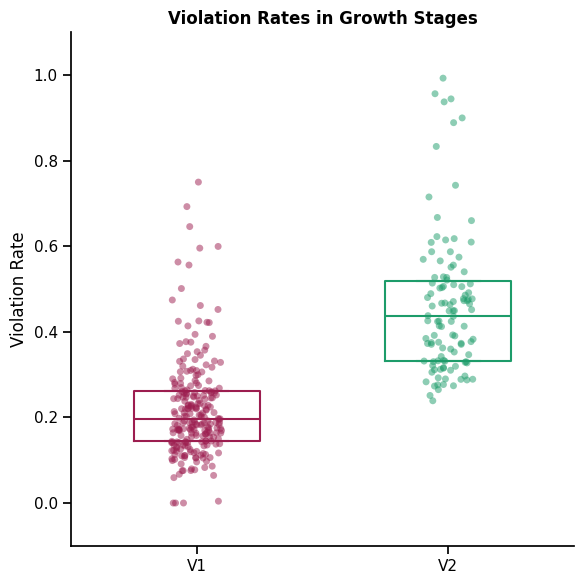

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
x = "fix_experiment"
y="violation_rate"
order=c.HUE_ORDER_EXP
hue_type="experiment"

sns.despine()

sns.boxplot(
    x=x,
    y=y,
    data=plot_df,
    order=order,
    ax=ax,
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    palette=c.EXP_PALETTE,
    fill=False,
    showfliers=False,
    whis=False,
    width=0.5,
)

if hue_type == "animal":
    hue = "animal_id"
    hue_order = c.HUE_ORDER_ANIMALS
    palette = c.ANIMAL_PALETTE
else:
    hue = "fix_experiment"
    hue_order = ["V1", "V2"]
    palette = c.EXP_PALETTE

sns.stripplot(
    x=x,
    y=y,
    data=plot_df,
    order=order,
    ax=ax,
    hue=hue,
    hue_order=hue_order,
    palette=palette,
    dodge=False,
    legend=False,
    alpha=0.5,
)
ax.set(
    ylabel="Violation Rate",
    ylim=(-0.1, 1.1),
    xlabel="",
)

ax.set_title("Violation Rates in Growth Stages", fontweight="bold")


plt.tight_layout()

#save fig
fig.savefig("figures/V0_fig4a_growth_violation_rates.png", dpi=300, bbox_inches="tight")



In [8]:

compare_v1_v2(plot_df, "violation_rate")
 

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,236,110,mannwhitney,2011.0,9.896279e-37


In [9]:
compare_v1_v2_multi_sample(plot_df, "violation_rate")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,7.444959,9.697458e-14,False


> Significant difference between V1 and V2 violation rates in growth stages


# B- N Attempted


In [10]:
plot_df = pdf.query("stage in @c.GROWING_STAGES") \
.groupby(["animal_id", "fix_experiment", "date"]) \
.agg(n_attempted=("animal_id", "size"), # each row is an attempted trial
     n_rewarded=("was_rewarded", "sum")).reset_index()
plot_df.head()

,animal_id,fix_experiment,date,n_attempted,n_rewarded
0,R040,V1,01-Aug-2024 14:28:29,439,319
1,R040,V1,02-Aug-2024 14:35:33,361,298
2,R040,V1,03-Aug-2024 14:05:41,420,351
3,R040,V1,04-Aug-2024 13:59:54,459,349
4,R040,V1,05-Aug-2024 13:59:14,380,300


In [11]:
plot_df.groupby("fix_experiment").agg(mean_n_attempted=("n_attempted", "mean"), std_n_attempted=("n_attempted", "std")).reset_index()

,fix_experiment,mean_n_attempted,std_n_attempted
0,V1,331.915254,107.183920
1,V2,469.181818,183.823718


/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication/utils.py:215: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=None, frameon=False)


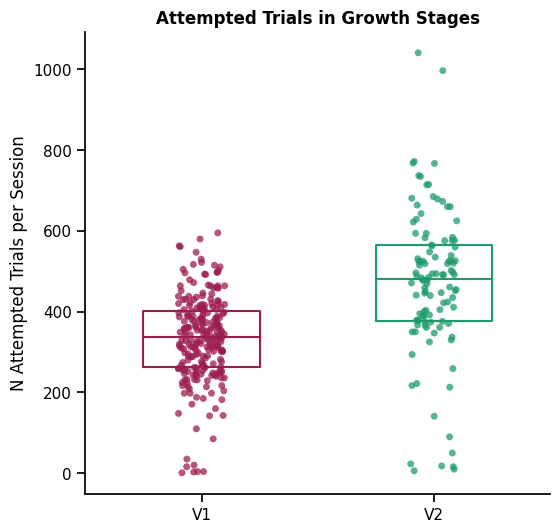

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

u.box_strip_v1_vs_v2(plot_df, x="fix_experiment", order=c.HUE_ORDER_EXP, y="n_attempted", ax=ax, xlabel="", ylabel="N Attempted Trials per Session")

ax.set_title("Attempted Trials in Growth Stages", fontweight="bold")


#save fig
fig.savefig("figures/V0_fig4b_n_attemped.png", dpi=300, bbox_inches="tight")

In [13]:
compare_v1_v2(plot_df, "n_attempted")

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,236,110,mannwhitney,5654.5,2.803017e-17


In [14]:
compare_v1_v2_multi_sample(plot_df, "n_attempted")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,3.343164,0.000828,False


> Significant difference between V1 and V2 attempted trials in growth stages


# C- N Rewarded


In [15]:
plot_df.groupby("fix_experiment").agg(mean_n_rewarded=("n_rewarded", "mean"), std_n_rewarded=("n_rewarded", "std")).reset_index()

,fix_experiment,mean_n_rewarded,std_n_rewarded
0,V1,246.834746,78.725393
1,V2,252.309091,110.002481


/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication/utils.py:215: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=None, frameon=False)


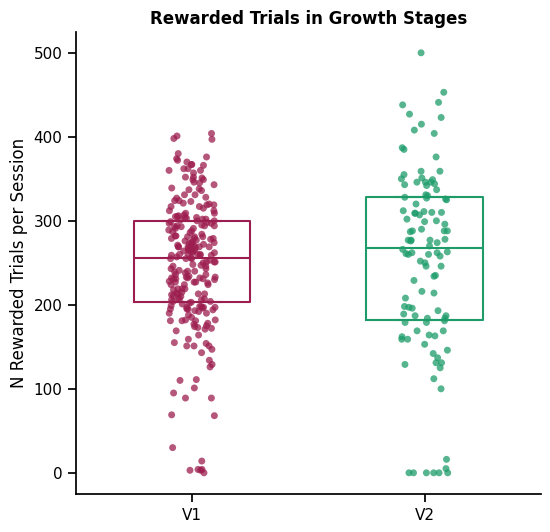

In [16]:
fig, ax = plt.subplots(figsize=(6,6))

u.box_strip_v1_vs_v2(plot_df, x="fix_experiment", order=c.HUE_ORDER_EXP, y="n_rewarded", ax=ax, xlabel="", ylabel="N Rewarded Trials per Session")

ax.set_title("Rewarded Trials in Growth Stages", fontweight="bold")


#save fig
fig.savefig("figures/V0_fig4c_n_rewarded.png", dpi=300, bbox_inches="tight")

In [17]:
compare_v1_v2(plot_df, "n_rewarded")

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,236,110,mannwhitney,12196.0,0.365825


In [18]:
compare_v1_v2_multi_sample(plot_df, "n_rewarded")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,0.409417,0.682233,False


> No significant difference between V1 and V2 rewarded trials in growth stages


# D- N Attempted Over Session


In [19]:
plot_df = pdf.query("stage in @c.GROWING_STAGES").copy()
plot_df["was_violation"] = plot_df["was_valid"] == 0

plot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129942 entries, 0 to 176099
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sessid                   129942 non-null  int64  
 1   animal_id                129942 non-null  object 
 2   trial                    129942 non-null  int64  
 3   cpoke_dur                128299 non-null  float64
 4   cpoke_iti                129942 non-null  float64
 5   post_settling_violation  129942 non-null  int64  
 6   settling_violation       129942 non-null  int64  
 7   was_rewarded             129942 non-null  int64  
 8   fixation_dur             129942 non-null  float64
 9   date                     129942 non-null  object 
 10  stage                    129942 non-null  float64
 11  fix_experiment           129942 non-null  object 
 12  relative_cpoke_dur       128299 non-null  float64
 13  was_valid                129942 non-null  bool   
 14  cpoke_tit

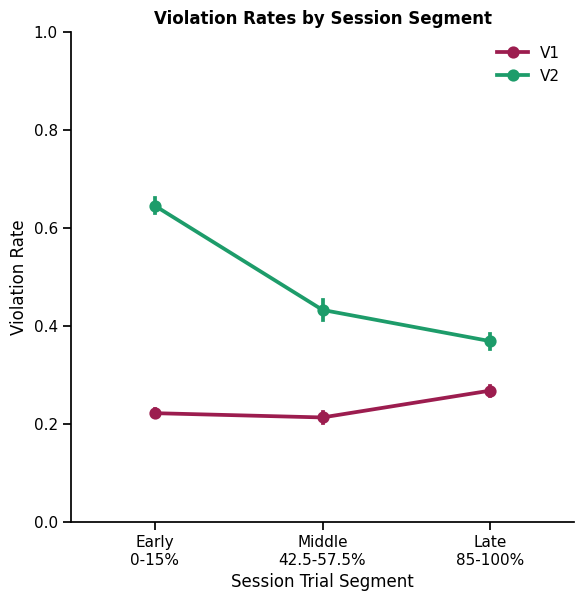

In [20]:

violations_over_sessions = compute_violation_rates_by_session(plot_df, pct=0.15)

# Now, plot the results as a box plot:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()
sns.pointplot(data=violations_over_sessions, x='segment', y='violation_rate', order=["early", "middle", "late"], hue='fix_experiment', palette=c.EXP_PALETTE, hue_order=c.HUE_ORDER_EXP, errorbar="se")

ax.set_title("Violation Rates by Session Segment", fontweight="bold")

ax.set(
    xlabel="Session Trial Segment",
    ylabel="Violation Rate",
    ylim=(0, 1)
)

plt.tight_layout()

ax.legend(title=None, frameon=False)

# get x tick labels and rename to ["early [0-10%]", "middle [45-55%]", "late [90-100%]"]
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Early\n0-15%", "Middle\n42.5-57.5%", "Late\n85-100%"])

# save fig
fig.savefig("figures/V0_fig4d_violation_rates_by_session_segment.png", dpi=300, bbox_inches="tight")

In [21]:

results = []
for group_name, group_data in violations_over_sessions.groupby('fix_experiment'):
    for seg_name, seg_data in group_data.groupby('segment'):
        # Apply Shapiro-Wilk test
        stat, p_value = shapiro(seg_data['violation_rate'])
        results.append({
            'fix_experiment': group_name,
            'segment': seg_name,
            'Shapiro_stat': stat,
            'p_value': p_value,
            'n': len(seg_data)
        })
pd.DataFrame(results)



,fix_experiment,segment,Shapiro_stat,p_value,n
0,V1,early,0.885087,2.131629e-12,236
1,V1,late,0.946716,1.644980e-07,232
2,V1,middle,0.836898,5.813914e-15,234
3,V2,early,0.973526,2.732094e-02,110
4,V2,late,0.955841,1.167200e-03,109
5,V2,middle,0.850865,3.811766e-09,110


> Results are not normal, so we will use a non-parametric test


In [22]:

# Pivot the data to wide format: one row per session with columns for each segment
pivot_df = violations_over_sessions.pivot_table(
    index=['sessid', 'animal_id', 'date', 'fix_experiment'],
    columns='segment',
    values='violation_rate'
).reset_index()


# Perform Friedman test for each fix_experiment group
friedman_results = {}
for group in pivot_df['fix_experiment'].unique():
    # For the Friedman test, require complete data for early, middle, and late.
    group_df = pivot_df[pivot_df['fix_experiment'] == group].dropna(subset=['early', 'middle', 'late'])
    
    # Run the Friedman test
    friedman_stat, friedman_p = friedmanchisquare(
        group_df['early'], group_df['middle'], group_df['late']
    )
    friedman_results[group] = {'friedman_stat': friedman_stat, 'p_value': friedman_p}
    
    print(f"\nFixation Group: {group}")
    print(f"Friedman Test Statistic: {friedman_stat:.4f}, p-value: {friedman_p:.4e}")



Fixation Group: V2
Friedman Test Statistic: 128.2024, p-value: 1.4495e-28

Fixation Group: V1
Friedman Test Statistic: 30.2146, p-value: 2.7478e-07


In [24]:

# If the Friedman test is significant within a group, you may follow up with pairwise comparisons.
# For pairwise comparisons, we use the Wilcoxon signed-rank test with a multiple comparisons correction.
pairwise_results = {}
for group in pivot_df['fix_experiment'].unique():
    group_df = pivot_df[pivot_df['fix_experiment'] == group].dropna(subset=['early', 'middle', 'late'])
    comparisons = list(combinations(['early', 'middle', 'late'], 2))
    results = []
    for comp in comparisons:
        stat, p_val = wilcoxon(group_df[comp[0]], group_df[comp[1]])
        results.append({'comparison': f'{comp[0]} vs {comp[1]}', 'wilcoxon_stat': stat, 'p_value': p_val})
    
    # Correct for multiple comparisons using Bonferroni correction (or Holm, etc.)
    p_values = [r['p_value'] for r in results]
    reject, pvals_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='bonferroni')
    for i, r in enumerate(results):
        r['p_value_corrected'] = pvals_corrected[i]
        r['reject_null'] = reject[i]
    pairwise_results[group] = results

tidy_results = []
for group, comparisons in pairwise_results.items():
    for comp in comparisons:
        tidy_results.append({
            'fix_experiment': group,
            'comparison': comp['comparison'],
            'wilcoxon_stat': comp['wilcoxon_stat'],
            'raw_p_value': comp['p_value'],
            'corrected_p_value': comp['p_value_corrected'],
            'reject_null': comp['reject_null']
        })

tidy_results_df = pd.DataFrame(tidy_results)
tidy_results_df

,fix_experiment,comparison,wilcoxon_stat,raw_p_value,corrected_p_value,reject_null
0,V2,early vs middle,201.0,3.665559e-16,1.099668e-15,True
1,V2,early vs late,7.0,1.551990e-19,4.655970e-19,True
2,V2,middle vs late,1807.5,2.776037e-03,8.328110e-03,True
3,V1,early vs middle,9885.0,1.632250e-02,4.896750e-02,True
4,V1,early vs late,9694.0,3.820143e-04,1.146043e-03,True
5,V1,middle vs late,6846.5,4.949752e-09,1.484926e-08,True


# E,F- TIT Analysis for Growth & Probe


,median,mean,std,size
fix_experiment,,,,
V1,9.4548,11.292175,5.428192,15237
V2,0.1366,1.014564,3.077032,21914


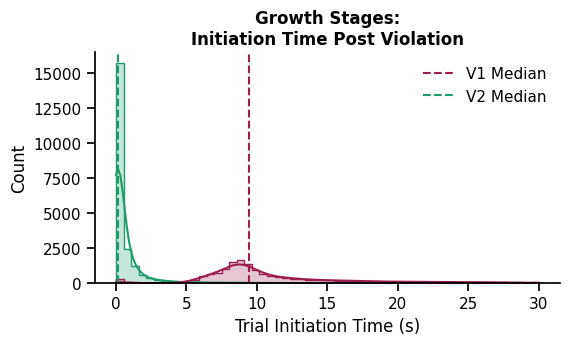

In [25]:
MAX_TIT = 30
plot_df = pdf.query("stage in @c.GROWING_STAGES and cpoke_tit_timeout_adj < @MAX_TIT and prev_was_valid==False")

fig, ax = plt.subplots(figsize=(6,3))
sns.despine()
sns.histplot(
    data=plot_df,
    x="cpoke_tit_timeout_adj",
    ax=ax,
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)
ax.set_title("Growth Stages:\nInitiation Time Post Violation", fontweight="bold")

ax.set(
    xlabel="Trial Initiation Time (s)",
)



# Calculate statistics for each fix_experiment
stats = plot_df.groupby('fix_experiment')['cpoke_tit_timeout_adj'].agg(['median', 'mean', 'std', 'size'])

# Print the statistics
(stats.reset_index())

# Plot median lines for each fix_experiment
for i, (exp, median) in enumerate(stats['median'].items()):
    ax.axvline(median, color=c.EXP_PALETTE[i], linestyle='--', label=f'{exp} Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
fig.savefig("figures/V0_fig4e_v2_violation_tit_growth.png", dpi=300, bbox_inches="tight")

stats

In [26]:

# Suppose df_v1 and df_v2 are the subsets of your data
stat, pval = ks_2samp(plot_df.query("fix_experiment == 'V1'")['cpoke_tit_timeout_adj'], plot_df.query("fix_experiment == 'V2'")['cpoke_tit_timeout_adj'])
print(f"KS statistic={stat}, p={pval}")

KS statistic=0.9320939673076558, p=0.0


In [27]:
compare_v1_v2(plot_df, metric_col="cpoke_tit_timeout_adj")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15237.
  res = hypotest_fun_out(*samples, **kwds)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21914.
  res = hypotest_fun_out(*samples, **kwds)


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,15237,21914,mannwhitney,321417712.5,0.0


## Probe Stages


,median,mean,std,size
fix_experiment,,,,
V1,9.292299,10.882296,6.049418,2196
V2,8.476650,9.757799,5.834757,2284


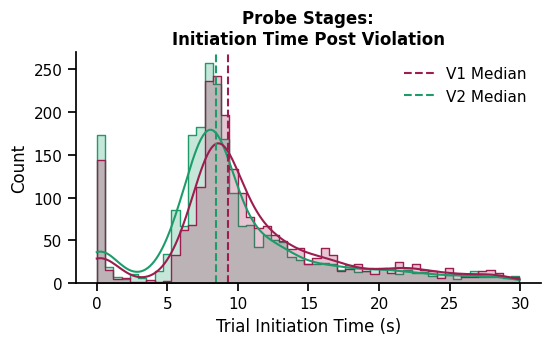

In [28]:
MAX_TIT = 30
plot_df = pdf.query("stage in @c.PROBE_STAGES and cpoke_tit_timeout_adj < @MAX_TIT and prev_was_valid==False")

fig, ax = plt.subplots(figsize=(6,3))
sns.despine()
sns.histplot(
    data=plot_df,
    x="cpoke_tit_timeout_adj",
    ax=ax,
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)
ax.set_title("Probe Stages:\nInitiation Time Post Violation", fontweight="bold")

ax.set(
    xlabel="Trial Initiation Time (s)",
)


# Calculate statistics for each fix_experiment
stats = plot_df.groupby('fix_experiment')['cpoke_tit_timeout_adj'].agg(['median', 'mean', 'std', 'size'])

# Print the statistics
(stats.reset_index())

# Plot median lines for each fix_experiment
for i, (exp, median) in enumerate(stats['median'].items()):
    ax.axvline(median, color=c.EXP_PALETTE[i], linestyle='--', label=f'{exp} Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")

fig.savefig("figures/V0_fig4f_v2_violation_tit_probe.png", dpi=300, bbox_inches="tight")
stats

In [29]:
# Suppose df_v1 and df_v2 are the subsets of your data
stat, pval = ks_2samp(plot_df.query("fix_experiment == 'V1'")['cpoke_tit_timeout_adj'], plot_df.query("fix_experiment == 'V2'")['cpoke_tit_timeout_adj'])
print(f"KS statistic={stat}, p={pval}")

KS statistic=0.14644202641963258, p=2.0761606600018397e-21


In [30]:
compare_v1_v2(plot_df, metric_col="cpoke_tit_timeout_adj")

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,2196,2284,mannwhitney,2904008.0,5.469632e-20


# G- V2 Transition To Penalty On


In [31]:
plot_df = u.compute_days_relative_to_stage(pdf.query("fix_experiment == 'V2'").copy(), stage=8)
plot_df = plot_df[~((plot_df['settling_violation'] == 1) & (plot_df['days_relative_to_stage_8'] >= 0))] # remove settling in violations since they are not a true violation once in stage 8

# compute the violation rate (1- was_valid rate) for the day prior to and after the penalty on (stage 8) for each animal
plot_df = plot_df.query("days_relative_to_stage_8 >=-1 and days_relative_to_stage_8 <= 1") \
    .groupby(["animal_id", "fix_experiment", "days_relative_to_stage_8", "stage"]).agg({"was_valid": "mean"}).reset_index()
plot_df["violation_rate"] = 1 - plot_df["was_valid"]
plot_df.head()

,animal_id,fix_experiment,days_relative_to_stage_8,stage,was_valid,violation_rate
0,R041,V2,-1,7.0,0.489744,0.510256
1,R041,V2,0,8.0,0.837963,0.162037
2,R041,V2,1,9.0,0.728814,0.271186
3,R043,V2,-1,7.0,0.617211,0.382789
4,R043,V2,0,8.0,0.854015,0.145985


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_38521/919808081.py:6: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(


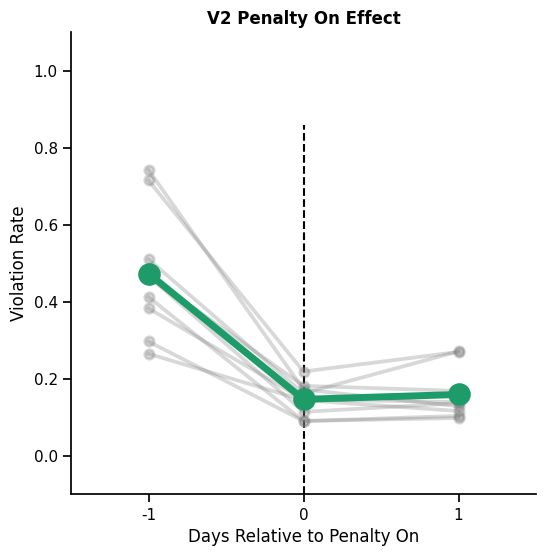

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()
day_range = [-1, 1]

ax.axvline(x=1, color="k", ls = "--", ymax=0.8)
sns.pointplot(
    data=plot_df,
    x="days_relative_to_stage_8",
    y="violation_rate",
    hue="animal_id",
    palette=["gray"],
    ax=ax,
    alpha=0.3,
    legend=False
)
sns.pointplot(
    data=plot_df,
    x="days_relative_to_stage_8",
    y="violation_rate",
    color=c.V2_COLOR,
    ax=ax,
    errorbar=None,
    linewidth=5,  # make the line thicker
)


ax.set(
    ylabel="Violation Rate",
    xlabel="Days Relative to Penalty On",
    ylim=(-0.1, 1.1),
)

ax.set_title("V2 Penalty On Effect", fontweight="bold")

fig.savefig("figures/V0_fig4g_v2_penalty_on.png", dpi=300, bbox_inches="tight")

In [33]:
plot_df.groupby(["days_relative_to_stage_8"]).agg(mean_violation_rate=("violation_rate", "mean"), std_violation_rate=("violation_rate", "std")).reset_index()

,days_relative_to_stage_8,mean_violation_rate,std_violation_rate
0,-1,0.473254,0.165425
1,0,0.146575,0.042910
2,1,0.159113,0.066473


In [34]:
df_wide = plot_df.pivot(index='animal_id', columns='days_relative_to_stage_8', values='violation_rate')

# Check the pivoted data (optional)
print(df_wide)

# Perform the Friedman test. Ensure you order the columns appropriately.
stat, p_value = friedmanchisquare(df_wide[-1], df_wide[0], df_wide[1])
print(f"Friedman test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Define the days to compare and perform pairwise Wilcoxon tests
days = [-1, 0, 1]
comparisons = list(itertools.combinations(days, 2))
alpha = 0.05
alpha_adjusted = alpha / len(comparisons)  # Bonferroni correction

for d1, d2 in comparisons:
    stat, p = wilcoxon(df_wide[d1], df_wide[d2])
    print(f"Comparison between day {d1} and day {d2}: Wilcoxon statistic = {stat:.4f}, p-value = {p:.4f} (adjusted α = {alpha_adjusted:.4f})")

days_relative_to_stage_8        -1         0         1
animal_id                                             
R041                      0.510256  0.162037  0.271186
R043                      0.382789  0.145985  0.139726
R045                      0.467480  0.181579  0.168508
R047                      0.296791  0.090379  0.097973
R049                      0.264940  0.144330  0.116216
R051                      0.412409  0.090090  0.103560
R053                      0.715200  0.218750  0.269663
R055                      0.742555  0.171975  0.128571
R057                      0.466867  0.114053  0.136612
Friedman test statistic: 13.5556
P-value: 0.0011
Comparison between day -1 and day 0: Wilcoxon statistic = 0.0000, p-value = 0.0039 (adjusted α = 0.0167)
Comparison between day -1 and day 1: Wilcoxon statistic = 0.0000, p-value = 0.0039 (adjusted α = 0.0167)
Comparison between day 0 and day 1: Wilcoxon statistic = 17.0000, p-value = 0.5703 (adjusted α = 0.0167)
